In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import camb
from camb import model, initialpower

In [2]:
def kzps(mnu_in, sigma12_in=1):
    """
    Returns the scale axis, redshifts, power spectrum, and sigma12
    of a Lambda-CDM model
    @param mnu : neutrino mass
    @param sigma12 : if the spectrum should be rescaled,
        this parameter determines the sigma12 of the model
        
    warning: this function currently supports only one redshift,
        z = 0. This is not for difficulty of implementation,
        but only to make absolutely sure that our toy example
        is simple until we've understood the basics.
    """
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=mnu_in, omk=0, tau=0.06)
    pars.InitPower.set_params(As = 2e-09, ns=0.965)
    pars.set_matter_power(redshifts=[0.], kmax=2.0)
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    results.calc_power_spectra(pars)
    
    if sigma12_in != 1:
        sigma12_unmodified = results.get_sigmaR(12, hubble_units=False)
        As_rescaled = 2e-9 * (sigma12_in / sigma12_unmodified) ** 2

        pars.InitPower.set_params(As = As_rescaled, ns=0.965)
        pars.set_matter_power(redshifts=[0.], kmax=2.0)
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        results.calc_power_spectra(pars)

    k, z, p = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)
    sigma12 = results.get_sigmaR(12, hubble_units=False)
    return k, z, p, sigma12

In [3]:
massive = []
massless = []

mnu_start = 0.06
mstep = 0.02
for i in range(0, 4):
    msum = mnu_start + mstep * i
    label = r"$\Sigma m_\nu = $" + str(msum) + " [eV]"
    k, z, p, s = kzps(msum, 1)
    massive.append((label, k, z, p, s))
    label0 = r"$\Sigma m_\nu = 0$ norm'd to " + str(msum)
    k0, z0, p0, s0 = kzps(0, s)
    massless.append((label0, k0, z0, p0, s0))

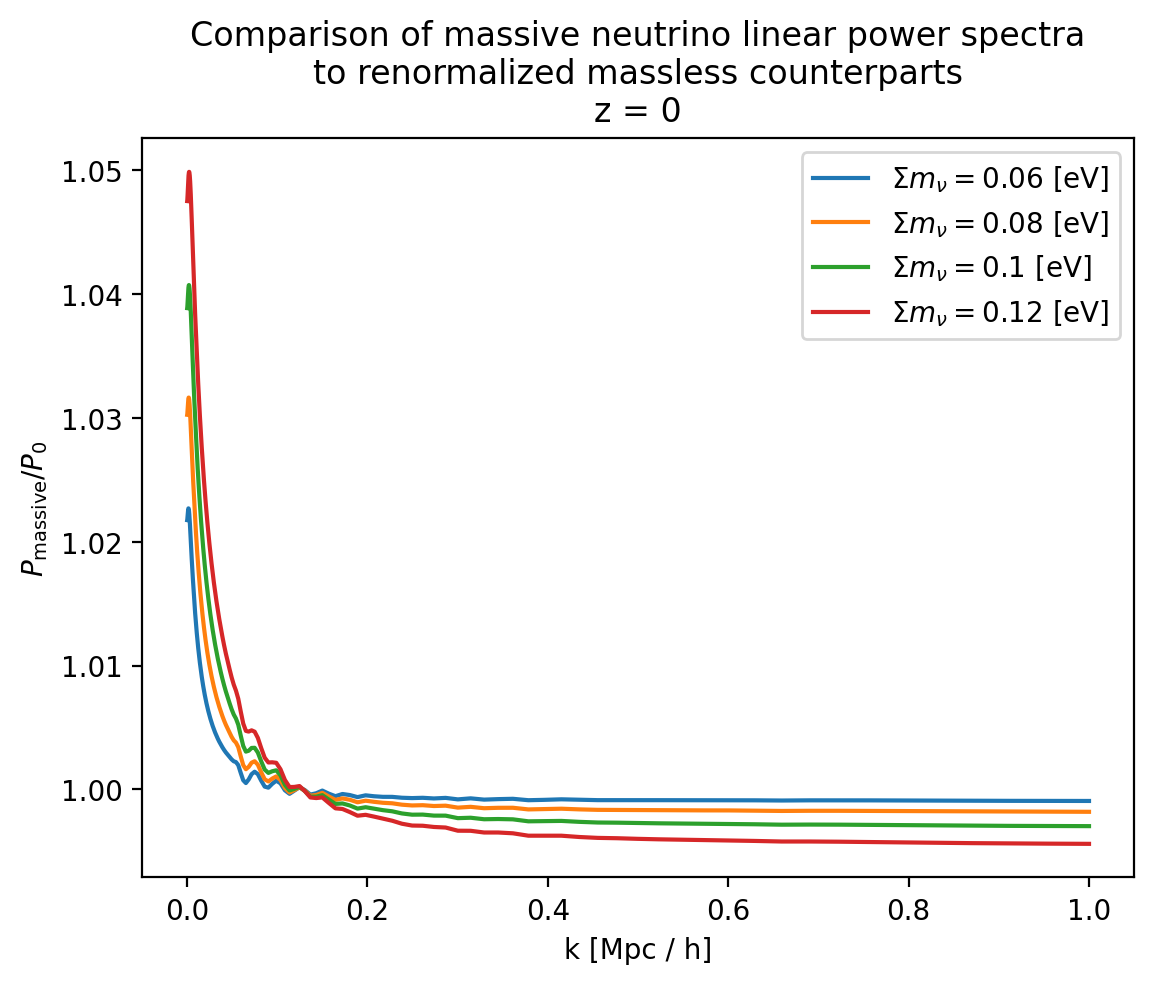

In [6]:
for i in range(len(massive)):
    plt.plot(massive[i][1], massive[i][3][0] / massless[i][3][0], label=massive[i][0])

title = "Comparison of massive neutrino linear power spectra\n" + \
    "to renormalized massless counterparts\n" + \
    "z = 0"
plt.title(title)
plt.xlabel(r"k [Mpc / h]")
plt.ylabel(r"$P_\mathrm{massive} / P_0$")
plt.legend()

Ivanov 2021 ("Cosmological Constraints...") puts the limit at M_tot < 0.64 eV 95% CL.

Planck 2018 data apparently puts the limit at M_tot < 0.12 eV for 95% CL.

    This is cited in Amiri et al, 2021 ("Constraining neutrino mass...")

Font-Ribera et al. 2014 ("DESI and other...") puts the limit at M_tot > 0.06 eV.